In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

plt.style.use("seaborn-white")
import seaborn as sns

sns.set_style("white")

from sklearn.model_selection import train_test_split

from torch import nn

In [2]:
from image_processing import upsample
from data import prepare_data, TGSSaltDataset
from visualisation import (
    plot_coverage_and_coverage_class,
    scatter_coverage_and_coverage_class,
    plot_depth_distributions,
    plot_images,
)
from model import model_path, save_checkpoint, update_state
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.utils import data

from resnetlike import UNetResNet
from training import train, test, RefineStep
from collections import defaultdict
import logging
import random
from utils import create_optimizer, tboard_log_path
import uuid
import itertools as it
from operator import itemgetter
import shutil
from tensorboardX import SummaryWriter
from config import load_config

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
now = datetime.datetime.now()

In [5]:
config = load_config()['Model']
logger.info(f'Loading config {config}')

INFO:config:Loading config ../configs/config.json
INFO:__main__:Loading config {'base_channels': 32, 'batch_size': 128, 'best_model_filename': 'best_model_state.pth', 'epochs': 70, 'id': '61464e07-ce3e-42b1-b88a-482d645756d8', 'img_target_size': 101, 'model_filename': 'model_{cycle}_state.pth', 'num_workers': 0, 'optimization_config': {'base_lr': 0.1, 'momentum': 0.9, 'nesterov': True, 'scheduler': {'lr_min': 0, 'num_cycles': 6, 'type': 'cosine'}, 'type': 'sgd', 'weight_decay': 0.0001}, 'seed': 42}


In [6]:
locals().update(config)

In [7]:
# img_size_target = 101
# batch_size = 128
# learning_rate = 0.1
# epochs = 70
# num_workers = 0
# seed = 42
# num_cycles = (
#     6
# )  # Using Cosine Annealing with warm restarts, the number of times to oscillate
# notebook_id = f"{now:%d%b%Y}_{uuid.uuid4()}"
# base_channels = 32
# config = {
#     "run_config": {
#         "arch": "shake_shake",
#         "base_channels": 64,
#         "depth": 26,
#         "shake_forward": True,
#         "shake_backward": True,
#         "shake_image": True,
#         "input_shape": (1, 1, img_size_target, img_size_target),
#     },
#     "optim_config": {
#         "optimizer": "sgd",
#         "base_lr": learning_rate,
#         "momentum": 0.9,
#         "weight_decay": 1e-4,
#         "nesterov": True,
#         "epochs": epochs,
#         "scheduler": "cosine",
#         "lr_min": 0,
#     },
# }

In [8]:
torch.backends.cudnn.benchmark = True
logger.info(f"Started {now}")
tboard_log = os.path.join(tboard_log_path(), f"log_{id}")
logger.info(f"Writing TensorBoard logs to {tboard_log}")
summary_writer = None #SummaryWriter(log_dir=tboard_log)

INFO:__main__:Started 2018-10-05 10:13:56.920730
INFO:__main__:Writing TensorBoard logs to /mnt/models/logs/pytorch_unet_resnetlike/bd788921eaa0c41ffafd30b72c4e312ba12e01e3/log_61464e07-ce3e-42b1-b88a-482d645756d8


In [9]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [10]:
model = UNetResNet(1, base_channels)

In [11]:
n_params = sum([param.view(-1).size()[0] for param in model.parameters()])
logger.info("n_params: {}".format(n_params))

INFO:__main__:n_params: 20419744


In [12]:
device = torch.device("cuda:0")
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): UNetResNet(
    (enc1): EncodingLayer(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (res1): PreactivationResidualBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (res2): PreactivationResidualBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [13]:
# Test to check network
x = torch.randn(16, 1, img_target_size, img_target_size).cuda()
model.forward(x).shape

torch.Size([16, 1, 101, 101])

In [14]:
train_df, test_df = prepare_data()

100%|██████████| 4000/4000 [00:01<00:00, 2447.65it/s]


In [15]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


/opt/conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


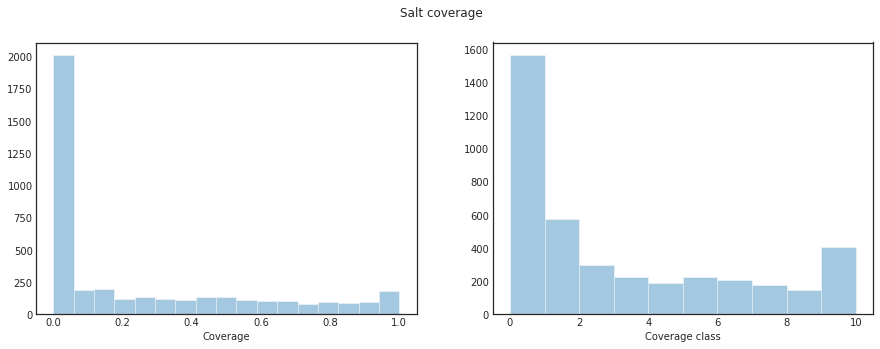

In [16]:
plot_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

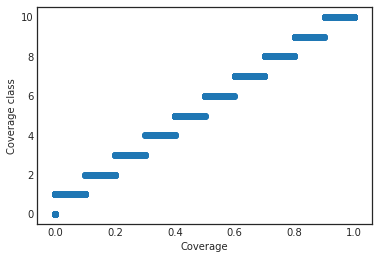

In [17]:
scatter_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

/opt/conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


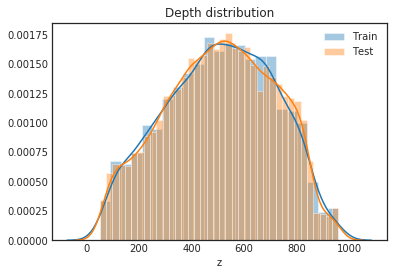

In [18]:
plot_depth_distributions(train_df.z, test_df.z)

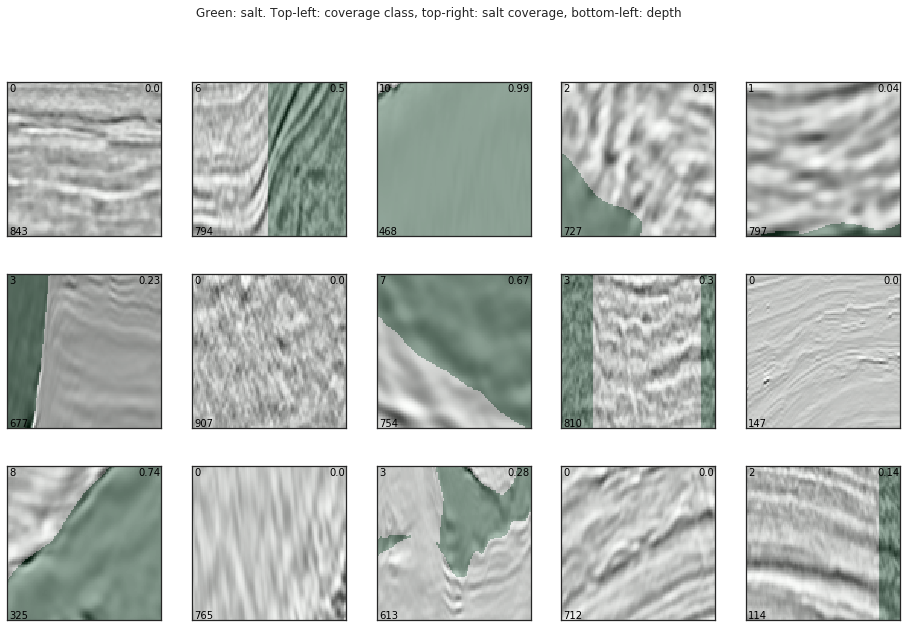

In [19]:
plot_images(train_df, max_images=15, grid_width=5, figsize=(16, 10))

In [20]:
upsample_to = upsample(101, img_target_size)

In [21]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample_to).tolist()).reshape(
        -1, 1, img_target_size, img_target_size
    ),
    np.array(train_df.masks.map(upsample_to).tolist()).reshape(
        -1, 1, img_target_size, img_target_size
    ),
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2,
    stratify=train_df.coverage_class,
    random_state=seed,
)

In [22]:
# Augment data with flipped verisons
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [23]:
x_train.shape

(6400, 1, 101, 101)

In [24]:
dataset = TGSSaltDataset(x_train, y_data=y_train)
dataset_val = TGSSaltDataset(x_valid, y_data=y_valid)

In [25]:
state = {
    "state_dict": None,
    "optimizer": None,
    "epoch": 0,
    "val_iou": 0,
    "best_val_iou": 0,
    "best_epoch": 0,
}

In [26]:
train_data_loader = data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True,
)
val_data_loader = data.DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False,
)

In [27]:
optimization_config["steps_per_epoch"] = len(train_data_loader)
optimization_config["epochs"] = epochs

In [28]:
model_dir=os.path.join(model_path(), f"{id}")
os.makedirs(model_dir, exist_ok=True)

In [29]:
history = defaultdict(list)
loss_fn = torch.nn.BCELoss()

global_counter = it.count()
cumulative_epochs_counter = it.count()
cycle_best_val_iou = {}

optimizer, scheduler = create_optimizer(model.parameters(), optimization_config)
step_func = RefineStep(loss_fn, scheduler, optimizer, summary_writer=summary_writer)

for cycle in range(optimization_config['scheduler']['num_cycles']):  # Cosine annealing with warm restarts
    optimizer, scheduler = create_optimizer(model.parameters(), optimization_config)
    step_func.set_optimizer(optimizer)
    step_func.set_scheduler(scheduler)
    for epoch in range(epochs):
        cum_epoch = next(cumulative_epochs_counter)
        train_metrics = train(
            cum_epoch,
            model,
            train_data_loader,
            step_func,
            summary_writer=summary_writer
        )

        val_metrics = test(
            cum_epoch, model, loss_fn, val_data_loader, summary_writer=summary_writer
        )

        state = update_state(
            state, cum_epoch, "val_iou", np.mean(val_metrics["iou"]), model, optimizer
        )

        save_checkpoint(state, outdir=model_dir, best_model_filename=model_filename.format(cycle=cycle))

        history["epoch"].append(cum_epoch)
        history["train_loss"].append(np.mean(train_metrics["loss"]))
        history["val_loss"].append(np.mean(val_metrics["loss"]))
        history["train_iou"].append(np.mean(train_metrics["iou"]))
        history["val_iou"].append(np.mean(val_metrics["iou"]))
    cycle_best_val_iou[cycle] = state["best_val_iou"]

INFO:training:Train 0
INFO:training:Epoch: 0,Train: loss 0.629,  IoU 0.141
INFO:training:Elapsed 12.36
INFO:training:Test 0
INFO:training:Epoch: 0,Val: loss 0.498, IoU 0.200 ** 
INFO:training:Elapsed 1.40
INFO:model:val_iou went from 0 to 0.2 >:)
INFO:training:Train 1
INFO:training:Epoch: 1,Train: loss 0.422,  IoU 0.306
INFO:training:Elapsed 10.50
INFO:training:Test 1
INFO:training:Epoch: 1,Val: loss 0.745, IoU 0.147 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 2
INFO:training:Epoch: 2,Train: loss 0.392,  IoU 0.390
INFO:training:Elapsed 9.44
INFO:training:Test 2
INFO:training:Epoch: 2,Val: loss 0.441, IoU 0.209 ** 
INFO:training:Elapsed 0.55
INFO:model:val_iou went from 0.2 to 0.209375 >:)
INFO:training:Train 3
INFO:training:Epoch: 3,Train: loss 0.380,  IoU 0.421
INFO:training:Elapsed 9.43
INFO:training:Test 3
INFO:training:Epoch: 3,Val: loss 0.587, IoU 0.031 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 4
INFO:training:Epoch: 4,Train: loss 0.377,  IoU 0.446
INFO:training:El

INFO:training:Train 36
INFO:training:Epoch: 36,Train: loss 0.192,  IoU 0.637
INFO:training:Elapsed 9.62
INFO:training:Test 36
INFO:training:Epoch: 36,Val: loss 0.183, IoU 0.594 ** 
INFO:training:Elapsed 0.57
INFO:training:Train 37
INFO:training:Epoch: 37,Train: loss 0.185,  IoU 0.641
INFO:training:Elapsed 9.48
INFO:training:Test 37
INFO:training:Epoch: 37,Val: loss 0.196, IoU 0.547 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 38
INFO:training:Epoch: 38,Train: loss 0.188,  IoU 0.639
INFO:training:Elapsed 9.44
INFO:training:Test 38
INFO:training:Epoch: 38,Val: loss 0.189, IoU 0.600 ** 
INFO:training:Elapsed 0.55
INFO:model:val_iou went from 0.596875 to 0.6 >:)
INFO:training:Train 39
INFO:training:Epoch: 39,Train: loss 0.184,  IoU 0.653
INFO:training:Elapsed 9.43
INFO:training:Test 39
INFO:training:Epoch: 39,Val: loss 0.180, IoU 0.581 ** 
INFO:training:Elapsed 0.56
INFO:training:Train 40
INFO:training:Epoch: 40,Train: loss 0.182,  IoU 0.643
INFO:training:Elapsed 9.55
INFO:training:T

INFO:training:Elapsed 9.57
INFO:training:Test 73
INFO:training:Epoch: 73,Val: loss 0.167, IoU 0.681 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 74
INFO:training:Epoch: 74,Train: loss 0.134,  IoU 0.707
INFO:training:Elapsed 9.45
INFO:training:Test 74
INFO:training:Epoch: 74,Val: loss 0.165, IoU 0.684 ** 
INFO:training:Elapsed 0.64
INFO:training:Train 75
INFO:training:Epoch: 75,Train: loss 0.135,  IoU 0.710
INFO:training:Elapsed 9.44
INFO:training:Test 75
INFO:training:Epoch: 75,Val: loss 0.157, IoU 0.644 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 76
INFO:training:Epoch: 76,Train: loss 0.132,  IoU 0.715
INFO:training:Elapsed 9.52
INFO:training:Test 76
INFO:training:Epoch: 76,Val: loss 0.163, IoU 0.631 ** 
INFO:training:Elapsed 0.60
INFO:training:Train 77
INFO:training:Epoch: 77,Train: loss 0.133,  IoU 0.707
INFO:training:Elapsed 9.47
INFO:training:Test 77
INFO:training:Epoch: 77,Val: loss 0.165, IoU 0.684 ** 
INFO:training:Elapsed 0.60
INFO:training:Train 78
INFO:training:

INFO:training:Elapsed 9.48
INFO:training:Test 112
INFO:training:Epoch: 112,Val: loss 0.161, IoU 0.666 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 113
INFO:training:Epoch: 113,Train: loss 0.097,  IoU 0.749
INFO:training:Elapsed 9.45
INFO:training:Test 113
INFO:training:Epoch: 113,Val: loss 0.165, IoU 0.697 ** 
INFO:training:Elapsed 0.61
INFO:training:Train 114
INFO:training:Epoch: 114,Train: loss 0.101,  IoU 0.747
INFO:training:Elapsed 9.37
INFO:training:Test 114
INFO:training:Epoch: 114,Val: loss 0.172, IoU 0.666 ** 
INFO:training:Elapsed 0.54
INFO:training:Train 115
INFO:training:Epoch: 115,Train: loss 0.090,  IoU 0.757
INFO:training:Elapsed 9.42
INFO:training:Test 115
INFO:training:Epoch: 115,Val: loss 0.174, IoU 0.691 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 116
INFO:training:Epoch: 116,Train: loss 0.086,  IoU 0.759
INFO:training:Elapsed 9.41
INFO:training:Test 116
INFO:training:Epoch: 116,Val: loss 0.225, IoU 0.697 ** 
INFO:training:Elapsed 0.56
INFO:training:Train

INFO:training:Epoch: 151,Train: loss 0.080,  IoU 0.770
INFO:training:Elapsed 9.47
INFO:training:Test 151
INFO:training:Epoch: 151,Val: loss 0.194, IoU 0.666 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 152
INFO:training:Epoch: 152,Train: loss 0.074,  IoU 0.772
INFO:training:Elapsed 9.48
INFO:training:Test 152
INFO:training:Epoch: 152,Val: loss 0.179, IoU 0.634 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 153
INFO:training:Epoch: 153,Train: loss 0.082,  IoU 0.765
INFO:training:Elapsed 9.35
INFO:training:Test 153
INFO:training:Epoch: 153,Val: loss 0.206, IoU 0.694 ** 
INFO:training:Elapsed 0.56
INFO:training:Train 154
INFO:training:Epoch: 154,Train: loss 0.084,  IoU 0.761
INFO:training:Elapsed 9.40
INFO:training:Test 154
INFO:training:Epoch: 154,Val: loss 0.170, IoU 0.722 ** 
INFO:training:Elapsed 0.54
INFO:training:Train 155
INFO:training:Epoch: 155,Train: loss 0.071,  IoU 0.776
INFO:training:Elapsed 9.46
INFO:training:Test 155
INFO:training:Epoch: 155,Val: loss 0.191, IoU 0

INFO:training:Elapsed 9.44
INFO:training:Test 189
INFO:training:Epoch: 189,Val: loss 0.210, IoU 0.703 ** 
INFO:training:Elapsed 0.56
INFO:training:Train 190
INFO:training:Epoch: 190,Train: loss 0.059,  IoU 0.798
INFO:training:Elapsed 9.49
INFO:training:Test 190
INFO:training:Epoch: 190,Val: loss 0.195, IoU 0.725 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 191
INFO:training:Epoch: 191,Train: loss 0.062,  IoU 0.792
INFO:training:Elapsed 9.47
INFO:training:Test 191
INFO:training:Epoch: 191,Val: loss 0.286, IoU 0.606 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 192
INFO:training:Epoch: 192,Train: loss 0.069,  IoU 0.783
INFO:training:Elapsed 9.44
INFO:training:Test 192
INFO:training:Epoch: 192,Val: loss 0.212, IoU 0.669 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 193
INFO:training:Epoch: 193,Train: loss 0.058,  IoU 0.796
INFO:training:Elapsed 9.42
INFO:training:Test 193
INFO:training:Epoch: 193,Val: loss 0.192, IoU 0.656 ** 
INFO:training:Elapsed 0.55
INFO:training:Train

INFO:training:Epoch: 228,Train: loss 0.050,  IoU 0.812
INFO:training:Elapsed 9.42
INFO:training:Test 228
INFO:training:Epoch: 228,Val: loss 0.193, IoU 0.750 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 229
INFO:training:Epoch: 229,Train: loss 0.069,  IoU 0.787
INFO:training:Elapsed 9.49
INFO:training:Test 229
INFO:training:Epoch: 229,Val: loss 0.205, IoU 0.716 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 230
INFO:training:Epoch: 230,Train: loss 0.061,  IoU 0.793
INFO:training:Elapsed 9.45
INFO:training:Test 230
INFO:training:Epoch: 230,Val: loss 0.238, IoU 0.728 ** 
INFO:training:Elapsed 0.56
INFO:training:Train 231
INFO:training:Epoch: 231,Train: loss 0.058,  IoU 0.799
INFO:training:Elapsed 9.48
INFO:training:Test 231
INFO:training:Epoch: 231,Val: loss 0.282, IoU 0.691 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 232
INFO:training:Epoch: 232,Train: loss 0.055,  IoU 0.799
INFO:training:Elapsed 9.43
INFO:training:Test 232
INFO:training:Epoch: 232,Val: loss 0.257, IoU 0

INFO:training:Test 266
INFO:training:Epoch: 266,Val: loss 0.211, IoU 0.756 ** 
INFO:training:Elapsed 0.56
INFO:training:Train 267
INFO:training:Epoch: 267,Train: loss 0.051,  IoU 0.812
INFO:training:Elapsed 9.55
INFO:training:Test 267
INFO:training:Epoch: 267,Val: loss 0.168, IoU 0.734 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 268
INFO:training:Epoch: 268,Train: loss 0.041,  IoU 0.824
INFO:training:Elapsed 9.42
INFO:training:Test 268
INFO:training:Epoch: 268,Val: loss 0.232, IoU 0.759 ** 
INFO:training:Elapsed 0.61
INFO:training:Train 269
INFO:training:Epoch: 269,Train: loss 0.041,  IoU 0.827
INFO:training:Elapsed 9.59
INFO:training:Test 269
INFO:training:Epoch: 269,Val: loss 0.195, IoU 0.753 ** 
INFO:training:Elapsed 0.56
INFO:training:Train 270
INFO:training:Epoch: 270,Train: loss 0.043,  IoU 0.824
INFO:training:Elapsed 9.43
INFO:training:Test 270
INFO:training:Epoch: 270,Val: loss 0.240, IoU 0.731 ** 
INFO:training:Elapsed 0.60
INFO:training:Train 271
INFO:training:Epoch: 2

INFO:training:Epoch: 304,Val: loss 0.211, IoU 0.719 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 305
INFO:training:Epoch: 305,Train: loss 0.046,  IoU 0.823
INFO:training:Elapsed 9.55
INFO:training:Test 305
INFO:training:Epoch: 305,Val: loss 0.241, IoU 0.719 ** 
INFO:training:Elapsed 0.57
INFO:training:Train 306
INFO:training:Epoch: 306,Train: loss 0.043,  IoU 0.823
INFO:training:Elapsed 9.58
INFO:training:Test 306
INFO:training:Epoch: 306,Val: loss 0.235, IoU 0.728 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 307
INFO:training:Epoch: 307,Train: loss 0.037,  IoU 0.841
INFO:training:Elapsed 9.45
INFO:training:Test 307
INFO:training:Epoch: 307,Val: loss 0.236, IoU 0.725 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 308
INFO:training:Epoch: 308,Train: loss 0.036,  IoU 0.843
INFO:training:Elapsed 9.38
INFO:training:Test 308
INFO:training:Epoch: 308,Val: loss 0.316, IoU 0.722 ** 
INFO:training:Elapsed 0.56
INFO:training:Train 309
INFO:training:Epoch: 309,Train: loss 0.052,  

INFO:training:Elapsed 9.51
INFO:training:Test 343
INFO:training:Epoch: 343,Val: loss 0.222, IoU 0.688 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 344
INFO:training:Epoch: 344,Train: loss 0.036,  IoU 0.834
INFO:training:Elapsed 9.47
INFO:training:Test 344
INFO:training:Epoch: 344,Val: loss 0.259, IoU 0.709 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 345
INFO:training:Epoch: 345,Train: loss 0.034,  IoU 0.840
INFO:training:Elapsed 9.55
INFO:training:Test 345
INFO:training:Epoch: 345,Val: loss 0.247, IoU 0.769 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 346
INFO:training:Epoch: 346,Train: loss 0.037,  IoU 0.840
INFO:training:Elapsed 9.50
INFO:training:Test 346
INFO:training:Epoch: 346,Val: loss 0.297, IoU 0.697 ** 
INFO:training:Elapsed 0.56
INFO:training:Train 347
INFO:training:Epoch: 347,Train: loss 0.037,  IoU 0.838
INFO:training:Elapsed 9.48
INFO:training:Test 347
INFO:training:Epoch: 347,Val: loss 0.303, IoU 0.719 ** 
INFO:training:Elapsed 0.54
INFO:training:Train

INFO:training:Epoch: 382,Train: loss 0.033,  IoU 0.844
INFO:training:Elapsed 9.44
INFO:training:Test 382
INFO:training:Epoch: 382,Val: loss 0.265, IoU 0.669 ** 
INFO:training:Elapsed 0.54
INFO:training:Train 383
INFO:training:Epoch: 383,Train: loss 0.029,  IoU 0.854
INFO:training:Elapsed 9.46
INFO:training:Test 383
INFO:training:Epoch: 383,Val: loss 0.260, IoU 0.700 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 384
INFO:training:Epoch: 384,Train: loss 0.027,  IoU 0.859
INFO:training:Elapsed 9.53
INFO:training:Test 384
INFO:training:Epoch: 384,Val: loss 0.247, IoU 0.684 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 385
INFO:training:Epoch: 385,Train: loss 0.027,  IoU 0.862
INFO:training:Elapsed 9.49
INFO:training:Test 385
INFO:training:Epoch: 385,Val: loss 0.302, IoU 0.706 ** 
INFO:training:Elapsed 0.55
INFO:training:Train 386
INFO:training:Epoch: 386,Train: loss 0.027,  IoU 0.857
INFO:training:Elapsed 9.41
INFO:training:Test 386
INFO:training:Epoch: 386,Val: loss 0.308, IoU 0

In [30]:
sorted_by_val_iou = sorted(cycle_best_val_iou.items(), key=itemgetter(1), reverse=True)
best_cycle, best_iou = sorted_by_val_iou[0]
logger.info(f"Best model cycle {best_cycle}: Validation IoU {best_iou}")
logger.info(f"Saving to {best_model_filename}")
shutil.copy(
    os.path.join(model_dir, model_filename.format(cycle=best_cycle)),
    os.path.join(model_dir, best_model_filename),
)

INFO:__main__:Best model cycle 4: Validation IoU 0.7718750000000001
INFO:__main__:Saving to best_model_state.pth


'/mnt/models/pytorch_unet_resnetlike/61464e07-ce3e-42b1-b88a-482d645756d8/best_model_state.pth'

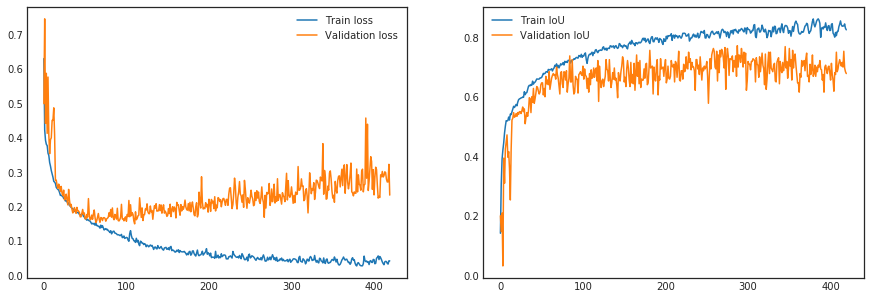

In [31]:
fig, (ax_loss, ax_iou) = plt.subplots(1, 2, figsize=(15, 5))
ax_loss.plot(history["epoch"], history["train_loss"], label="Train loss")
ax_loss.plot(history["epoch"], history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_iou.plot(history["epoch"], history["train_iou"], label="Train IoU")
ax_iou.plot(history["epoch"], history["val_iou"], label="Validation IoU")
ax_iou.legend()